# Drawing

I'm working here on a drawing environment similar to [Zelle's graphics](https://mcsp.wartburg.edu/zelle/python/index.html) for use in [Jupyter notebooks](https://jupyter.org/) based on [ipycanvas](https://ipycanvas.readthedocs.io/en/latest/) .

The idea is to give students an API to work in an object oriented style, but without requiring them to install Tk on their own laptop. The advantage of the jupyter notebook is that I can run it in the cloud on a [jupyter hub](https://github.com/jupyterhub/the-littlest-jupyterhub).

The point of using objects as shapes in Zelle's approach is to let them act as objects which can be moved and (with sleep as a delay) animated and interacted with. Zelle's API gives the window the ability to wait for clicks, and lets the objects be moved around accordinly in a code loop.

But what I'm finding is that much of that model is pretty awkward in ipycanvas. The ipycanvas API expects a single canvas at the end of the cell which "is" the illustration.

So building all of Zelle's API seems somewhat impractical. The "evaluate a cell and see the result" model implicit in these notebooks is fundamentally different than running an interactive window with Zelle's API. It is possible to force a correspondance with callbacks and event handlers, but all that added complexity means that error reporting is awkward and the complexity increased.

So building out all of Zelle's API as a drop in jupyter replacement feels impractical. But for some simple cases, something like Zelle's API may work for my purposes.

I've decided that rather than Zelle's "Window" or the ipycanvas "Canvas", I'll implement a "Drawing" object as the container for all this.

One complication is none of the Canvas displays are understood by the jupyter notebook interface; at least, "save as html" does not keep the images or animations as they would for matplotlib graphics. Oops. There are workarounds - the images can be saved to files, or exported to numpy ndarrays and then shown with matplotlib. Those operations need to happen in a different cell, or in a callback, to ensure that the render operation has completed. 

A few cases that may work for my fall 2020 "Intro CS" class at Bennington :

(1) Sol Levitt line drawings : no interaction, simply a function to implement the recipe, inherited from some base Drawing class. Creating a RoughLine class for for hand-draw-like irregular lines (google "rough js") could also be fun. That could allow a student midterm project within jupyter.

(2) Simple animations : a controller that moves components, using a simplistic "undraw" that erases them with the background color. (Or perhaps with a MultiCanvas, with a static drawing on the bottom layer and animation components on other layers.) I'm thinking of a recursive solitaire puzzle for a final project, which could be visualized within jupyter this way.


I have not yet included rectangles, arcs, text fields, or mouse click handlers.

Jim Mahoney | July 2020 | cs.bennington.college | MIT License

In [46]:
from ipycanvas import Canvas, MultiCanvas
import random, time
import numpy as np
from numpy import pi, sqrt, sin, cos
import matplotlib.pyplot as plt
from IPython.core.display import HTML

class Drawing(MultiCanvas):
    """ A drawing made of shapes.
    
        >>> d = Drawing()
        >>> d.add( Line(0,0, 100,100, 'red') )
        >>> d.add( Circle(40,50, 20, 'green') )
        >>> d.show()
    """

    defaults = {
        'background' : '#000000ff',  # black opaque (default)
        'border' : '#888888ff',      # grey opaque (default)
        'width' : 500,               # pixels
        'height' : 500
    }
    
    # For debugging, use "Drawing(...).draw()"" rather than "Drawing(...).show()"" .
    # Either one returns the drawing to be displayed and should be the last thing in a cell.
    # The difference is that .show() invokes a callback to do the rendering 
    # when jupyter is ready, which allows for progressive displays and animation,
    # while .draw() only displays when all the rendering is complete.
    # But a drawback to callbacks like .show() is that errors are not displayed
    # but instead just silently fail ... making debugging errors difficult.
        
    def __init__(self, caching=True, n_canvases=2, **kwargs):
        # layer 0 (i.e. ._canvas[0] ) will be a static background
        # layer 1 (i.e. ._canvas[1] ) is the default for components
        assert n_canvases >= 2
        for key in Drawing.defaults.keys():
            if kwargs.get(key, None) == None:
                kwargs[key] = Drawing.defaults[key]
        MultiCanvas.__init__(self, **kwargs)
        self.caching = caching
        self.n_canvases = n_canvases
        self.i_canvas = 1                # index of active canvas layer
        self.background = kwargs['background']
        self.border = kwargs['border']
        self.width = kwargs['width']
        self.height = kwargs['height']
        self.sync_image_data = True  # needed for .get_image_data()
        self._show_image_data = None
        self.components = []

    def canvas(self):
        return self._canvases[self.i_canvas]
        
    def add(self, shape):
        """ Add a shape to this drawing. """
        # Equivalent to passing a drawing to a shape 
        # when it is created, i.e. SomeShape(..., drawing=<this_drawing>)
        shape.drawing = self
        self.components.append(shape)
        
    def draw(self):
        """ Render and display this scene and all its components."""
        # In the ipycanvas dispaly model, the last line of the cell
        # must be the drawing itself. This function returns the drawing
        # so that a call to .draw() or .show() can be that last cell line.
        # If operations are cached, then .flush() renders them all at once. 
        self.draw_background()
        for component in self.components:
            component.draw()
        if self.caching:
            self.flush()
        return self

    def draw2(self):
        """ Render & display version 2"""
        # using matplotlib so that "save as html" keeps the image
        # This is a replacement for .draw(), not .show().
        # In other words, it won't do the right thing for animations.
        #
        # And this still needs some thought - without a callback,
        # this one *cannot* be done in the same cell, since ipycanvas
        # hasn't rendered it yet ... needs a callback (!?)
        #
        dpi = 300
        plt.figure(figsize=(self.width/dpi, self.height/dpi), dpi=dpi)
        ax = plt.axes([0,0,1,1], frameon=False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.autoscale(tight=True)
        try:
            data = self._show_image_data or self.get_image_data()
            plt.imshow(data)
        except Exception as e:
            print("Oops - couldn't get image data" + str(e))
    
    def draw_background(self):
        """ Initalize drawing with its default background color and border on layer 0. """
        layer0 = self._canvases[0]
        layer0.fill_style = self.background
        layer0.fill_rect(0, 0, self.width, self.height)
        if self.border:
            layer0.line_width = 2
            layer0.stroke_style = self.border
            layer0.stroke_rect(0, 0, self.width, self.height)
        self.flush()

    def show(self):
        """ Render an animation using a callback when jupyter is ready """
        self.on_client_ready(lambda:self.draw())
        return self
    
    def show2(self):
        """ Render an animation using a callback when jupyter is ready """
        # ... trying to do this with the matplotlib drawing approach
        self.on_client_ready(lambda:self.draw2())
        #return self

    def set_image_data(self):
        self._show_image_data = self.get_image_data()
        
    def show3(self):
        """ trying yet again to get matplotlib display to work"""
        # still doesn't work ... callback isn't called.
        #
        # related : 
        #  https://jakevdp.github.io/blog/2013/06/01/ipython-notebook-javascript-python-communication/
        #  ... obsolete ?
        # set a callback to fill in image_data once jupyter is ready for it
        # (1) render the image
        self.draw()
        # (2) get the image data
        self.observe(lambda:self.set_image_data(), 'image_data')
        for i in range(100):
            time.sleep(0.01)      # hope that callback will get run
        # (3) display with matploblib
        self.draw2()       

class SequentialDrawing(Drawing):
    """ A Drawing in which each component is rendered after a time delay dt. """
    def __init__(self, dt=0.01, **kwargs):
        Drawing.__init__(self, **kwargs)
        self.dt = dt
    def draw(self):
        self.draw_background()
        for component in self.components:
            time.sleep(self.dt)
            component.draw()
        return self        

class AnimatedDrawing(Drawing):
    """ A Drawing that draws and moves Shapes by calling their 'step' method. """
    #
    # In order to avoid (a) flickering and (b) shadows left by attempts at erasing moving shapes,
    # I'm currently implementing this with 3 layers: a static background and
    # two layers for rendering the moving shapes. If at some animation step the situation is
    #     layer 2   blank
    #     layer 1   rendered components 
    #     layer 0   background
    # then the component positions are updated, rendered on layer 2, and then layer 1 is cleared,
    # thus avoiding the flicker of a blank screen resulting from first erasing then re-rendering.
    #
    # See also https://developer.mozilla.org/en-US/docs/Web/API/Canvas_API/Tutorial/Basic_animations
    #  
    def __init__(self, dt=0.01, stop=3.0, **kwargs):
        kwargs['n_canvases'] = 3
        Drawing.__init__(self, **kwargs)
        self.dt = dt
        self.stop_time = stop
        self.elapsed_time = 0.0        
    def is_done(self):
        """ Return True when the animation is finished. """
        return self.elapsed_time >= self.stop_time
    def draw(self):
        self.draw_background()
        while not self.is_done():
            time.sleep(self.dt)
            self.elapsed_time += self.dt            # tick tock
            stale = self.i_canvas
            self.i_canvas = self.i_canvas % 2 + 1   #  alternate active layer : (1,2) => (2,1)
            for component in self.components:       # for each shape
                component.step(self.dt)             #    move it to its new place
                component.draw()                    #    draw it on the (new) active layer,
            self._canvases[stale].clear()           # then erase all old of layer
        return self
    
class Shape:
    """ A circle, line, text, rectangle, or other graphics component within a drawing """
    default_color = '#ffffffff' # white opaque (default background is black)
    def __init__(self, x=0, y=0, size=1, color=default_color, drawing=None):
        self.x = x
        self.y = y
        self.size = size
        self.color = color
        self.drawing = drawing
        if drawing:
            drawing.add(self)
    def draw(self):
        # Override this : use the drawing's canvas to implement per shape type
        pass
    def move(self, dx, dy):
        # This simply updates the position without rendering.
        self.x += dx
        self.y += dy
    def step(self, dt):
        # Override this to update the shapes properties for an animation
        pass

class Circle(Shape):
    " A circle with properties (x, y, radius, color) "
    def __init__(self, x=0, y=0, radius=1.0, color=Shape.default_color, drawing=None):
        self.radius = radius
        Shape.__init__(self, x, y, 2*radius, color, drawing)
    def draw(self):
        if self.drawing:
            c = self.drawing.canvas()
            c.save()
            c.fill_style = self.color
            c.fill_arc(self.x, self.y, self.radius, 0.0, 2*pi)
            c.restore()

class Ball(Circle):
    """ A moving circle, constant velocity, bouncing off the walls. """
    def __init__(self, x=0, y=0, dx=1.0, dy=1.0, radius=1.0, 
                 color=Shape.default_color, drawing=None):
        Circle.__init__(self, x, y, radius, color, drawing)
        self.dx = dx
        self.dy = dy
    def step(self, dt):
        self.move(self.dx, self.dy)
        if self.x - self.radius < 0 or self.x + self.radius > self.drawing.width:
            self.dx = -1 * self.dx
        if self.y - self.radius < 0 or self.y + self.radius > self.drawing.height:
            self.dy = -1 * self.dy

class Line(Shape):
    """ A straight line between two points with given color and width """
    def __init__(self, x0=0.0, y0=0.0, x1=1.0, y1=1.0, 
                 color=Shape.default_color, 
                 width=2,
                 drawing=None):
        Shape.__init__(self, (x0+x1)/2, (y0+y1/2), max(abs(x0-x1), abs(y0-y1)), drawing)
        self.x0 = x0
        self.y0 = y0
        self.x1 = x1
        self.y1 = y1
        self.width = width
        self.color = color
    def draw(self):
        if self.drawing:
            c = self.drawing.canvas()
            c.save()
            c.begin_path()
            c.line_width = self.width
            c.stroke_style = self.color
            c.move_to(self.x0, self.y0)
            c.line_to(self.x1, self.y1)
            c.stroke()
            c.restore()

def _random_circle():
    """ Return random (x, y) within a circle at (0,0) with radius 1 """
    # I always have to think about how to justify the sqrt() in this algorithm.
    # The argument goes something like this.
    #  * The random() function gives a uniform probability distribution from 0 to 1.
    #  * Points chosen randomly from a circular area are more likely to have larger r,
    #    since rings of width dr grow in size linearly . There's just more area at larger r,
    #    and so they are not distributed in a uniform distribution.
    #  * If our random() function gives us lets say a value x=0.25, then what that means is
    #    that 25% of the uniform points are below that, and 75% of the uniform points are above.
    #    We need to find the corresponding r for c(r), the circular probability distribution,
    #    that has that same property that 25% of the r values are smaller, and 75% are bigger.
    #  * So what we really need to think about are not u(x) and c(r), but U(x) and C(r),
    #    the cumulative probability distributions, with dU/dx=u(x)=x and dC/dr=c(r)=2*x.
    #    In this case, these cumulative distributions are U(x) = x  and C(r) = r**2.
    #  * Let's make the defintions explicit.
    #       x = random variable 0 <= x < 1 with uniform probability.
    #       r = random variable 0 <= r < 1 with circle radius probability.
    #       u(x) = "probability density of finding x between x and x+dx" = 1
    #       c(r) = "probability densiity of finding r between r and r+dr" = 2*r
    #       U(x) = "cumulative probability of finding x' between 0 and x" = x
    #       C(r) = "cumulative probability of finding r' between 0 and r" = r**2
    #  * So at a give value, say that 25% point, U=0.25=C, r=sqrt(C)=sqrt(0.25)=0.5.
    #    In other words, 25% of the circle has r<0.5, 75% has r>0.5.
    #  * Therefore what we want is 
    #       C(r) = U(x)           same cumulative probabilities at corresponding r, x
    #       r = C_inverse(U(x))   general formula connecting random variables r, x
    #       r = sqrt(x)           this case
    (r, theta) = (sqrt(random.random()), 2*pi*random.random())
    return (r*cos(theta), r*sin(theta))

def _normalize(x, y):
    """ return (x_norm, y_norm) with unit length in same direction as (x,y) """
    _length = sqrt(x*x + y*y)
    return (x/_length, y/_length)

class RoughLine(Shape):
    """ A hand-drawn-like line between two points, with color, width, and roughness """
    # See https://shihn.ca/posts/2020/roughjs-algorithms/
    # Given line endpoints (start, end) and a "roughness" parameter,
    # the approach here defines a Bézier curve
    # (see en.wikipedia.org/wiki/B%C3%A9zier_curveand
    #      developer.mozilla.org/en-US/docs/Web/API/CanvasRenderingContext2D/bezierCurveTo)
    #      apoorvaj.io/cubic-bezier-through-four-points/ )
    # I'm going to fairly arbitrarily choose thise points : 
    #     A  -------   B   ----  C  ------ D
    # A is within a circle centered at "start", radius="roughness"
    # D is within a circle centered at "end", radius="roughness"
    # B is a Bezier control point (not in the line), with A -> B direction from A,
    #   from 0.45 to 0.55 of line from start to end, and (0.3 to 0.6) roughness above that line
    # C is a similar Bezier control point, also above the line in the same way,
    #   but from 0.65 to 0.75 from start to end
    # (Actually finding control points from points on the line is too much algebra for me.
    #  This seems similar in concept to the JS Roughness lines, which apparently work OK.
    #  But I don't want a zig-zag from above to below the nominal line, so both B & C are 'above')
    def __init__(self, x0=0.0, y0=0.0, x1=1.0, y1=1.0, 
                 color=Shape.default_color, 
                 width=2,
                 roughness=1,
                 drawing=None):
        self.x0 = x0
        self.y0 = y0
        self.x1 = x1
        self.y1 = y1
        #
        (_xa, _ya) = _random_circle()
        self.xa = xa = self.x0 + _xa * roughness
        self.ya = ya = self.y0 + _ya * roughness
        #
        (_x_para, _y_para) = _normalize(x1 - x0, y1 - y0) # parallel 
        _length = sqrt((x1 - x0)**2 + (y1 - y0)**2)
        (_x_perp, _y_perp) = (- _y_para, _x_para)         # perpendicular
        #
        _b_para = 0.45 + 0.1 * random.random()
        _b_perp = 0.3 * (1 + random.random()) * roughness
        self.xb = self.x0 + _b_para * _length * _x_para + _b_perp * _x_perp
        self.yb = self.y0 + _b_para * _length * _y_para + _b_perp * _y_perp
        #
        _c_para = 0.65 + 0.1 * random.random()
        _c_perp = 0.3 * (1 + random.random()) * roughness
        self.xc = self.x0 + _c_para * _length * _x_para + _c_perp * _x_perp
        self.yc = self.y0 + _c_para * _length * _y_para + _c_perp * _y_perp
        #
        (_xd, _yd) = _random_circle()
        self.xd = xd = self.x1 + _xd * roughness
        self.yd = yd = self.y1 + _yd * roughness
        #
        Shape.__init__(self, (xa+xd)/2, (ya+yd/2), 
                       max(abs(xa-xd), abs(ya-yd)), drawing)
        self.width = width
        self.color = color
        self.roughness = roughness
    def draw(self):
        if self.drawing:
            c = self.drawing.canvas()
            c.save()
            c.begin_path()
            c.line_width = self.width
            c.stroke_style = self.color
            c.move_to(self.xa, self.ya)
            c.bezier_curve_to(self.xb, self.yb, self.xc, self.yc, self.xd, self.yd)
            c.stroke()
            if False:
                # debugging by drawing four bezier points
                for (x,y) in ((self.xa, self.ya), (self.xb, self.yb), 
                              (self.xc, self.yc), (self.xd, self.yd)):
                    c.fill_style = 'red'
                    c.fill_arc(x, y, 3, 0.0, 2*pi)
            c.restore()


In [50]:
oncemore = Drawing()
oncemore.add( Line(10,10, 100,100) )
oncemore.draw()

Drawing(sync_image_data=True, width=500)

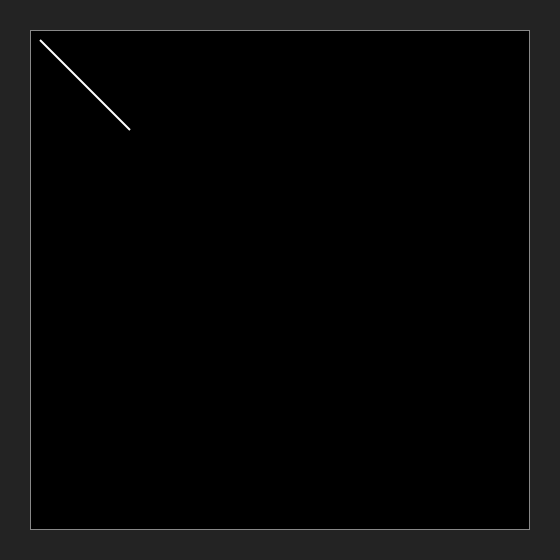

In [37]:
# color utilities
# See also https://webcolors.readthedocs.io/en/1.11.1/ 
# e.g. webcolors.CSS3_NAMES_TO_HEX .
# which doesn't however seem to handle transparency.

def byte2hex(number):
    """ Convert a number from 0 to 255 to a two digit hex string. """
    assert 0 <= number <= 255
    result = hex(number)[2:]
    return result if len(result) == 2 else '0' + result

assert byte2hex(0) == '00'
assert byte2hex(10) == '0a' 
assert byte2hex(255) == 'ff'

def random_color():
    """ return random html color '#rgbt' including transparency e.g. '#763904c5' """
    return '#' + ''.join([byte2hex(random.randint(0,255)) for i in range(4)])

assert len(random_color()) == 9
assert random_color()[0] == '#' 
assert all(x in '0123456789abcdef' for x in random_color()[1:])

In [12]:
# Example 1 : circles appearing with uniform random positions, sizes, colors, transparency
# (Visible below cell after evalution; however, is *not* seen in "download as HTML")

(dt, r_min, r_max, size, n) = (0.05, 3, 30, 400, 300) # delay, circle radius, frame, count
print(f"Drawing {n} random circles in {dt*n} sec.")
circle_draw = SequentialDrawing(dt=dt, width=size, height=size)
for i in range(n):
    circle_draw.add( Circle(x = random.randint(0, size), 
                            y = random.randint(0, size), 
                            radius = random.randint(r_min, r_max), 
                            color = random_color())   )
circle_draw.show()

Drawing 300 random circles in 15.0 sec.


SequentialDrawing(height=400, sync_image_data=True, width=400)

In [13]:
# Save to a file.
circle_draw.to_file('random_circles.png')

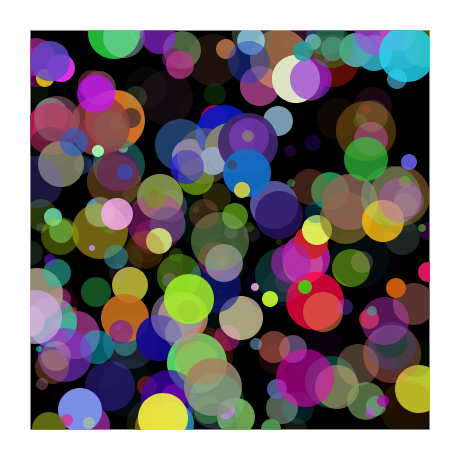

In [14]:
circle_draw.draw2() # this one, using matplotlib to draw it, *is* visible in "download as HTML"

In [15]:
# Example 2 : a bouncing ball.

animation = AnimatedDrawing(dt=1/30, width=200, height=200, stop=15)
animation.add( Ball(x=30, y=40, radius=20, dx=1, dy=3, color='yellow') )
print(f"Bouncing ball for {animation.stop_time} sec ...")
animation.show()

Bouncing ball for 15 sec ...


AnimatedDrawing(height=200, sync_image_data=True, width=200)

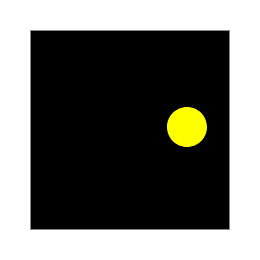

In [16]:
animation.draw2() # This is only the last frame of the animation.

In [17]:
# Example 3 : lines

def myrand(low=10, hi=20):
    return random.randint(low, hi)

print("Drawing some lines.")
line_draw = Drawing()
for i in range(50):
    (x0, y0) = (myrand(), myrand() + i/53 * line_draw.height)
    (x1, y1) = (line_draw.width - myrand(), y0 + 3*myrand() - 10)
    line_draw.add( Line(x0, y0, x1, y1, random_color(), width=3) )
line_draw.show()

Drawing some lines.


Drawing(sync_image_data=True, width=500)

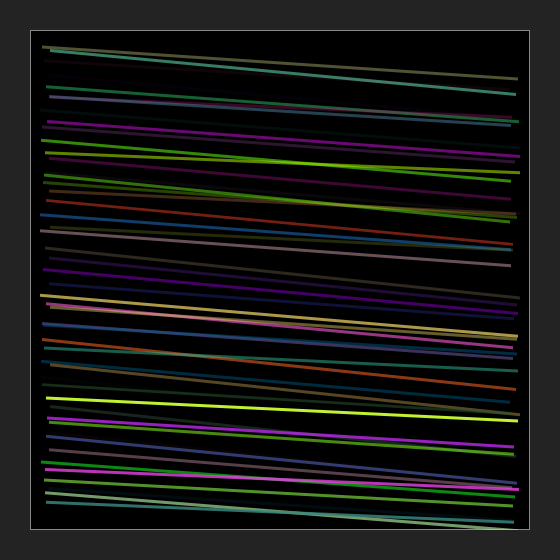

In [33]:
line_draw.draw2()

In [19]:
print("Hand drawn stars.")
star_drawing = Drawing()

def star(x, y, size, color, roughness):
    for i in range(5):
        theta0 = 4 * pi * i / 5
        theta1 = 4 * pi * (i+1) / 5
        x0 = x + size * cos(theta0)
        y0 = y + size * sin(theta0)
        x1 = x + size * cos(theta1)
        y1 = y + size * sin(theta1)
        star_drawing.add( RoughLine(x0, y0, x1, y1, color=color, roughness=roughness ) )

star(300, 300, 50, 'blue', 5)     
star(100, 200, 40, 'green', 5)
star(150, 400, 60, 'yellow', 5)
star(400, 150, 80, 'red', 5)
                     
star_drawing.draw()

Hand drawn stars.


Drawing(sync_image_data=True, width=500)

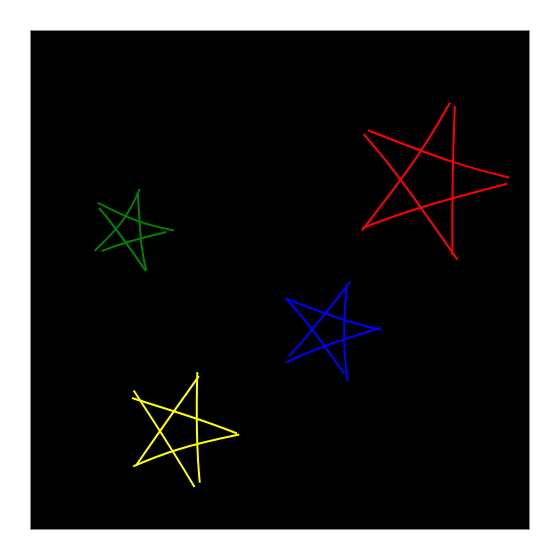

In [20]:
star_drawing.to_file('stars.png')
star_drawing.draw2()

## playground

----

In [21]:
# an animation in ipycanvas with the on_client_ready callback

canvas = Canvas(width=400, height=100)
def draw_ellipse():
    theta = np.linspace(0, -2*np.pi, num=300)  # negative => draw counter clockwise
    x = np.cos(theta) * canvas.width/2.5 + canvas.width/2 
    y = np.sin(theta) * canvas.height/2.5 + canvas.height/2
    canvas.caching = False                     # progressive, so don't save it for flush()
    canvas.fill_style = '#66666688'                        # rgbt background
    canvas.fill_rect(0, 0, canvas.width, canvas.height)    # paint background
    canvas.line_width = 3                   # path parameters
    canvas.stroke_style = 'yellow'          # 
    for i in range(1, len(x)):
        time.sleep(0.01)                       # animation delay
        canvas.begin_path()                    # start remembering graphics primitives
        canvas.move_to(x[i-1], y[i-1])
        canvas.line_to(x[i], y[i])
        canvas.stroke()                        # stop remembering & render this path
canvas.on_client_ready(draw_ellipse)  # callback rendering function when jupyter is ready
canvas                                # the canvas object needs to be the last thing in the cell

Canvas(height=100, width=400)

In [22]:
# list of color names and their hex representations
import webcolors
webcolors.CSS3_NAMES_TO_HEX

{'aliceblue': '#f0f8ff',
 'antiquewhite': '#faebd7',
 'aqua': '#00ffff',
 'aquamarine': '#7fffd4',
 'azure': '#f0ffff',
 'beige': '#f5f5dc',
 'bisque': '#ffe4c4',
 'black': '#000000',
 'blanchedalmond': '#ffebcd',
 'blue': '#0000ff',
 'blueviolet': '#8a2be2',
 'brown': '#a52a2a',
 'burlywood': '#deb887',
 'cadetblue': '#5f9ea0',
 'chartreuse': '#7fff00',
 'chocolate': '#d2691e',
 'coral': '#ff7f50',
 'cornflowerblue': '#6495ed',
 'cornsilk': '#fff8dc',
 'crimson': '#dc143c',
 'cyan': '#00ffff',
 'darkblue': '#00008b',
 'darkcyan': '#008b8b',
 'darkgoldenrod': '#b8860b',
 'darkgray': '#a9a9a9',
 'darkgrey': '#a9a9a9',
 'darkgreen': '#006400',
 'darkkhaki': '#bdb76b',
 'darkmagenta': '#8b008b',
 'darkolivegreen': '#556b2f',
 'darkorange': '#ff8c00',
 'darkorchid': '#9932cc',
 'darkred': '#8b0000',
 'darksalmon': '#e9967a',
 'darkseagreen': '#8fbc8f',
 'darkslateblue': '#483d8b',
 'darkslategray': '#2f4f4f',
 'darkslategrey': '#2f4f4f',
 'darkturquoise': '#00ced1',
 'darkviolet': '#9400d3

In [23]:
# Trying out composting ... which works in ipycanvas, 
# though it isn't documented explicitly on the canvas site.
#
# See developer.mozilla.org/en-US/docs/Web/API/CanvasRenderingContext2D/globalCompositeOperation .
# This ight be a way to make irregular toned beziers, by drawing on top of something blotchy. 
#
# *lots* of different operations, including 
# source-over, destination-over, lighten, darken, multiply, xor, ...

canvas = Canvas(width=200, height=200)
canvas.global_composite_operation = 'lighten' 
canvas.fill_style = 'blue';
canvas.fill_rect(10, 10, 100, 100);
canvas.fill_style = 'red';
canvas.fill_rect(50, 50, 100, 100);
canvas

Canvas(height=200, width=200)

In [26]:
def matplotlibdraw(canvas):
    """ display a canvas using the matplotlib's imshow """
    # ... so that "download as HTML" keeps the image
    dpi = 300
    plt.figure(figsize=(canvas.width/dpi, canvas.height/dpi), dpi=dpi)
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)
    try:
        plt.imshow(canvas.get_image_data())
    except Exception as e:
        print(e)

In [27]:
# Trying to draw a canvas with the matplotlib routines, so that "download as HTML" keeps the image.

# I've tried a few variations including their .observer(...) callback,
# but only got this version - with rendering & drawing in different cells - 
# to work with matplotlib=True

c3 = Canvas(width=200, height=200)

def render(canvas):
    canvas.caching = True
    canvas.sync_image_data = True
    canvas.fill_style='blue'
    canvas.fill_rect(0, 0, 200, 200)
    canvas.fill_style='yellow'
    canvas.fill_rect(20, 30, 120, 150)
    canvas.flush()

def drawit(canvas, matplotlib=True):
    if matplotlib:
        matplotlibdraw(canvas)
    else:
        return canvas

render(c3)
drawit(c3, matplotlib=False)  # this works using Canvas drawing, but doesn't go into "download as HTML"'s output

Canvas(height=200, sync_image_data=True, width=200)

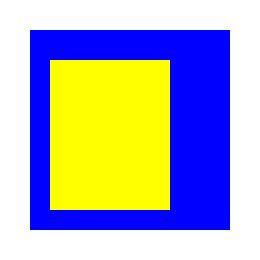

In [28]:
drawit(c3, matplotlib=True) # this works using matplotlib, but needs to be in a second cell

In [29]:
# Another try.

c4 = Canvas(width=200, height=200)

def render4(canvas):
    canvas.caching = True
    canvas.sync_image_data = True
    canvas.fill_style='green'
    canvas.fill_rect(0, 0, 200, 200)
    canvas.fill_style='cyan'
    canvas.fill_rect(20, 30, 120, 150)
    canvas.flush()

def drawit(canvas, matplotlib=True):
    if matplotlib:
        matplotlibdraw(canvas)
    else:
        display(canvas)      # Trying "display" rather than "return" ... which works.
        #return canvas

render4(c4)
drawit(c4, matplotlib=False) 

# Same : I can either draw from this cell but that isn't remembered for "download as HTML"

Canvas(height=200, sync_image_data=True, width=200)

# theme explorations

Attempts at making a dark theme work.

After some trial-and-error, I settled on using the Firefox's Stylus add-on at
https://addons.mozilla.org/en-US/firefox/addon/styl-us/ and "Jupyter Notebook Amazing Theme" 
from https://userstyles.org/styles/180070/jupyter-notebook-amazing-theme. 

Plot styles also need some tweaking for dark mode; see the example below.

The "jt" command line "jupytertheme" utility can also make changes 
to my user profile which (at least some of the time) modify the 
jupyter notebook appearence. By default that hides the logo and 
some buttons at the top of the notebook window ... not what I want.

In [ ]:
# This was an attempt to unhide the toolbar and noteboik name 
# after set_nb_theme hid them ... but I saw no affect.

#from jupyterthemes.stylefx import toggle_settings
#from IPython.core.display import HTML
#css_settings = toggle_settings(toolbar=True, nbname=True, hideprompt=False, kernellogo=True)
#display(HTML(''.join(['<style> ', css_settings, ' </style>'])))

In [ ]:
# And this changes the cursor color so that it isn't hidden in a firefox dark mode,
# even without a funky dark them. Adapted from 
# https://stackoverflow.com/questions/59619561/changing-text-cursor-color-in-jupyter-notebooks
# See also https://github.com/cemoody/ipynb_base16_dark/blob/master/custom.css

#def myDarkCursorFix():
#    from IPython.core.display import HTML
#    # 669933 - pale blue
#    # 838184 - light brown
#    # 7b93d1 - medium blue
#    # d0daf5 - whiteish blue
#    cursor_style = '3px solid #d0daf5'
#    select_background = '7b93d1'
#    display(HTML('<style> '
#                 '.cm-s-ipython .CodeMirror-cursor {border-left:' + cursor_style + '!important;}'
#                 '.cm-s-ipython div.CodeMirror-selected ' 
#                 '{background: #' + select_background + '; color:#393939 !important} '
#                 '</style>'))
#myDarkCursorFix()

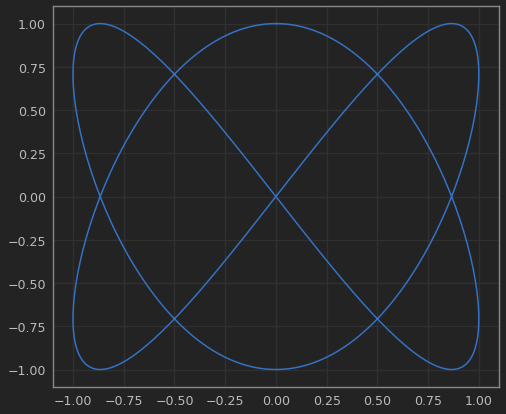

In [31]:
# dark theme plot example

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook')

t = np.linspace(0, 2*pi, num=500)
plt.plot(sin(2*t), cos(3*t))
None # supress plot object representation

In [32]:
# list available "jupytertheme" themes
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl
